In [15]:
import torch
import numpy as np
from typing import Tuple


class CusumMeanDetector():

    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit

        self._reset()



    def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()

        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint

        else:
            return 0, False


    def _reset(self) -> None:
        self.current_t = torch.zeros(1)

        self.current_obs = []

        self.current_mean = None
        self.current_std = None


    def _update_data(self, y: torch.tensor) -> None:
        self.current_t += 1
        #print("b:",str(y)," a:",str(y.reshape(1)))
        self.current_obs.append(y.reshape(1))



    def _init_params(self) -> None:
        self.current_mean = torch.mean(torch.concat(self.current_obs))
        self.current_std = torch.std(torch.concat(self.current_obs))


    def _check_for_changepoint(self) -> Tuple[float,bool]:
        standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean)/(self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum).detach().numpy())

        return prob, prob < self._p_limit


    def _get_prob(self, y: torch.tensor) -> bool:
        p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
        prob = 2*(1 - p)

        return prob

C:\Users\tikyn\AppData\Local\Temp\ipykernel_10428\2381946499.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(self._get_prob(standardized_sum).detach().numpy())


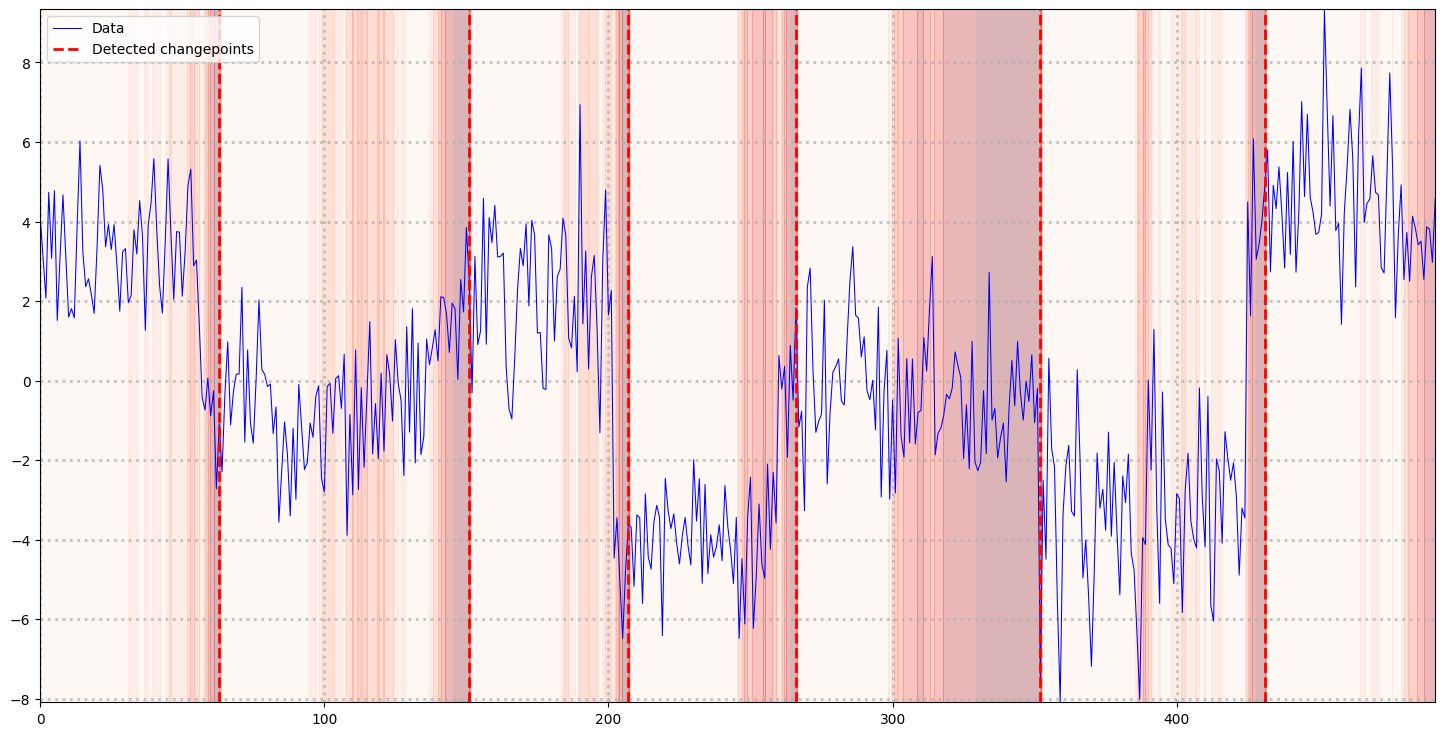

In [16]:
import matplotlib.pyplot as plt

import pandas as pd

import pandas as pd
#df=pd.read_csv("/content/test.csv", header=None, squeeze=True)

#y = torch.tensor(df.T.values)
np.random.seed(456)
torch.manual_seed(456)

segment_lengths = [np.random.randint(30,100) for _ in range(7)]


y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])

test = CusumMeanDetector()
#outs = [test.predict_next(y[i][0]) for i in range(len(y))]

outs = [test.predict_next(y[i]) for i in range(len(y))]

cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()
plt.show()

In [62]:
def GraphZscore(y, threshold,windowmax):
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),y,lw=0.75,label="Data",color="blue")
  """
  # 1.1 definisco i z standardized value ad ogni finestra di 100ms con step = 1 e li stampo
  i=0
  zscore=[]
  windows_range=[]
  while (i+100)<len(y):
    windows_range.append([i,i+100])
    c_win = y[i:i+100]
    c_mean = np.mean(c_win)
    c_std = np.std(c_win)
    c_zscore = []
    for j in c_win:
      c_zscore.append((j-c_mean)/c_std)
    zscore.append(c_zscore)
    i=i+1
  #piccolo check per controllare che se mi avanza una finestra finale da 70 a 100, creo una mini finestra da 30 finale
  if i+100 <len(y)-1:
    windows_range.append([i,len(y)])
    c_win = y[i:len(y)]
    c_mean = np.mean(c_win)
    c_std = np.std(c_std)
    c_zscore = []
    for j in c_win:
      c_zscore.append((j-c_mean)/c_std)
    zscore.append(c_zscore)
  plt.figure(figsize=(18,9))
  for idx,j in enumerate(zscore):
    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j)

  # 1.2 applico cusum su finestra temporale che cambia ogni 100ms
  cusum_1=[]
  for j in zscore:
    sh_res=[0]
    sl_res=[0]
    sh=0
    sl=0
    w=0.5
    for idx,k in enumerate(j):
      if idx==0:
        continue
      sh=max(0, sh+k-w)
      sl=max(0, sl-k-w)
      sh_res.append(sh)
      sl_res.append(sl)
    cusum_1.append([sh_res,sl_res])

  plt.figure(figsize=(18,9))
  for idx,j in enumerate(cusum_1):

    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j[0],'r')
    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j[1],'b')
  """
  # 2.1 applico cusum dove aggiorno la media e varianza se ce stato un changepoint

  c2_sh_res=[0]
  c2_sl_res=[0]
  c2_z_res=[]
  c2_change=[]
  c2_mean = np.mean(y[0:windowmax])
  c2_std = np.std(y[0:windowmax])
  windowrange=[[0,windowmax]]
  print(c2_std)
  c2_sh = 0
  c2_sl = 0
  w=0.5
  for idx,j in enumerate(y):

    # salto perche il sh e sl si fa considerando il valore precedente e in -1 non ho valori
    if idx == 0:
      continue
    c2_z = (j-c2_mean)/c2_std
    c2_z_res.append(c2_z)
    c2_sh = max(0, c2_sh+c2_z-w)
    c2_sl = max(0, c2_sl-c2_z-w)
    c2_sh_res.append(c2_sh)
    c2_sl_res.append(c2_sl)
    #print(c2_sh," ",c2_std," ",idx)
    smul = 0.5
    
    if c2_sh > threshold or c2_sl > threshold:
      
      c2_change.append([idx])
      c2_sh = 0
      c2_sl = 0
   
      if idx+100 >= len(y):
        windowrange.append([idx,len(y)])
        c2_mean = np.mean(y[idx:len(y)])
        c2_std = np.std(y[idx:len(y)])

      else:
        #print("else")
        windowrange.append([idx,idx+windowmax])
        c2_mean = np.mean(y[idx:idx+windowmax])
        c2_std = np.std(y[idx:idx+windowmax])



  for j in windowrange:
    plt.axvline(x = j[0], color = 'g',alpha=0.2)
    plt.axvline(x = j[1], color = 'r',alpha=0.2)
   
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)-1),c2_z_res,'g')

  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),c2_sh_res,color="green")
  for j in c2_change:
    plt.axvline(x = j, color = 'b',alpha=0.2)

  plt.plot(np.arange(len(y)),c2_sl_res,color="red")
  print("z")
  print(c2_z_res)
  print("c2_sh")
  print(c2_sh_res)
  print("c2_sl")
  print(c2_sl_res)
  plt.legend()
  plt.show()

  return c2_change

11242.0


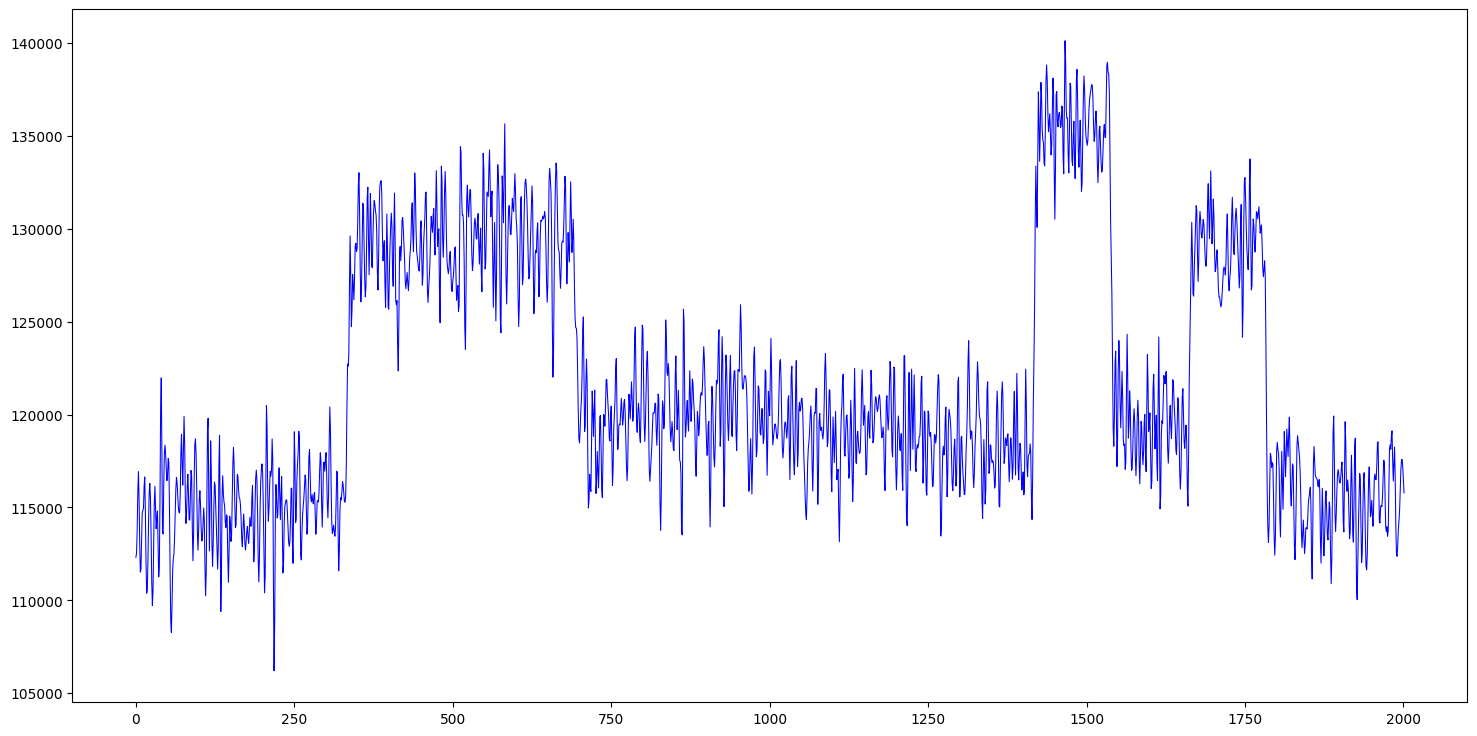

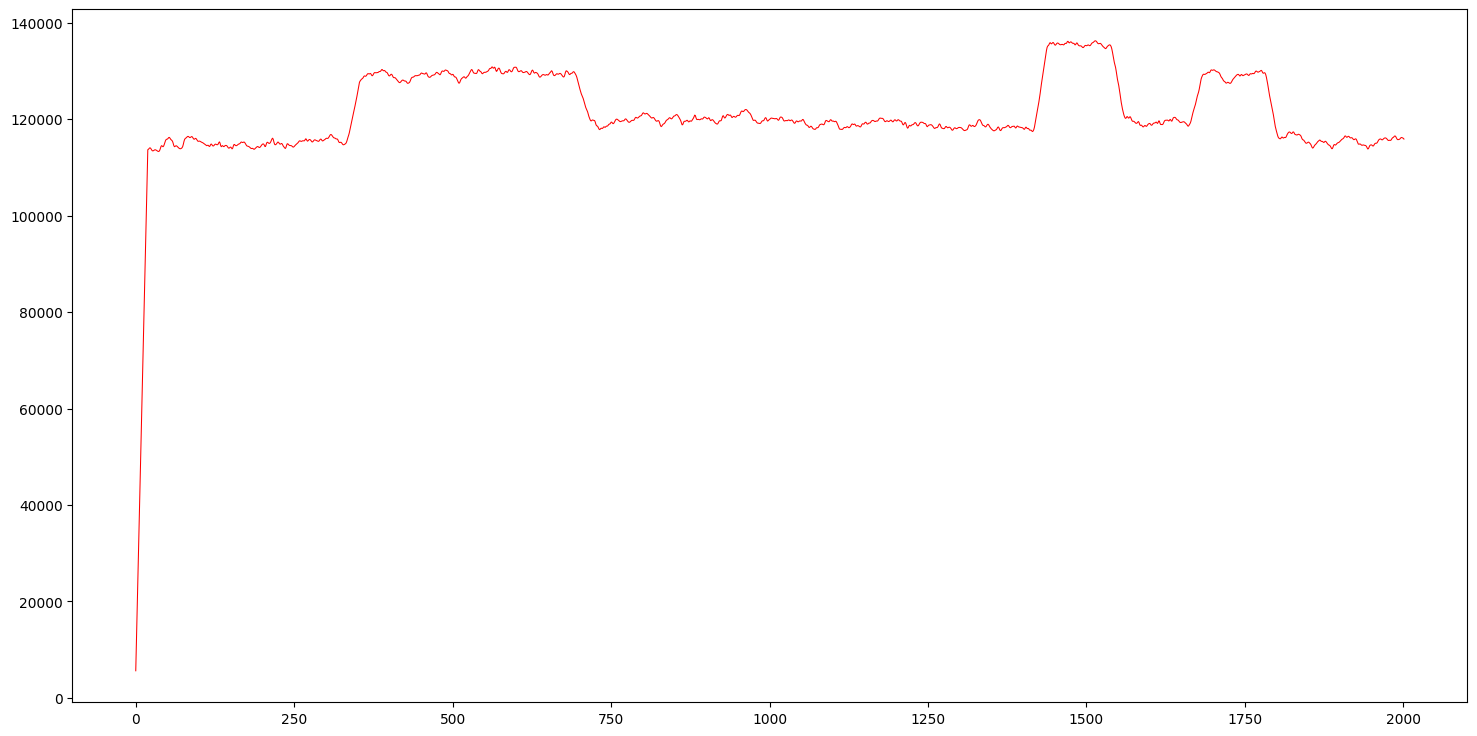

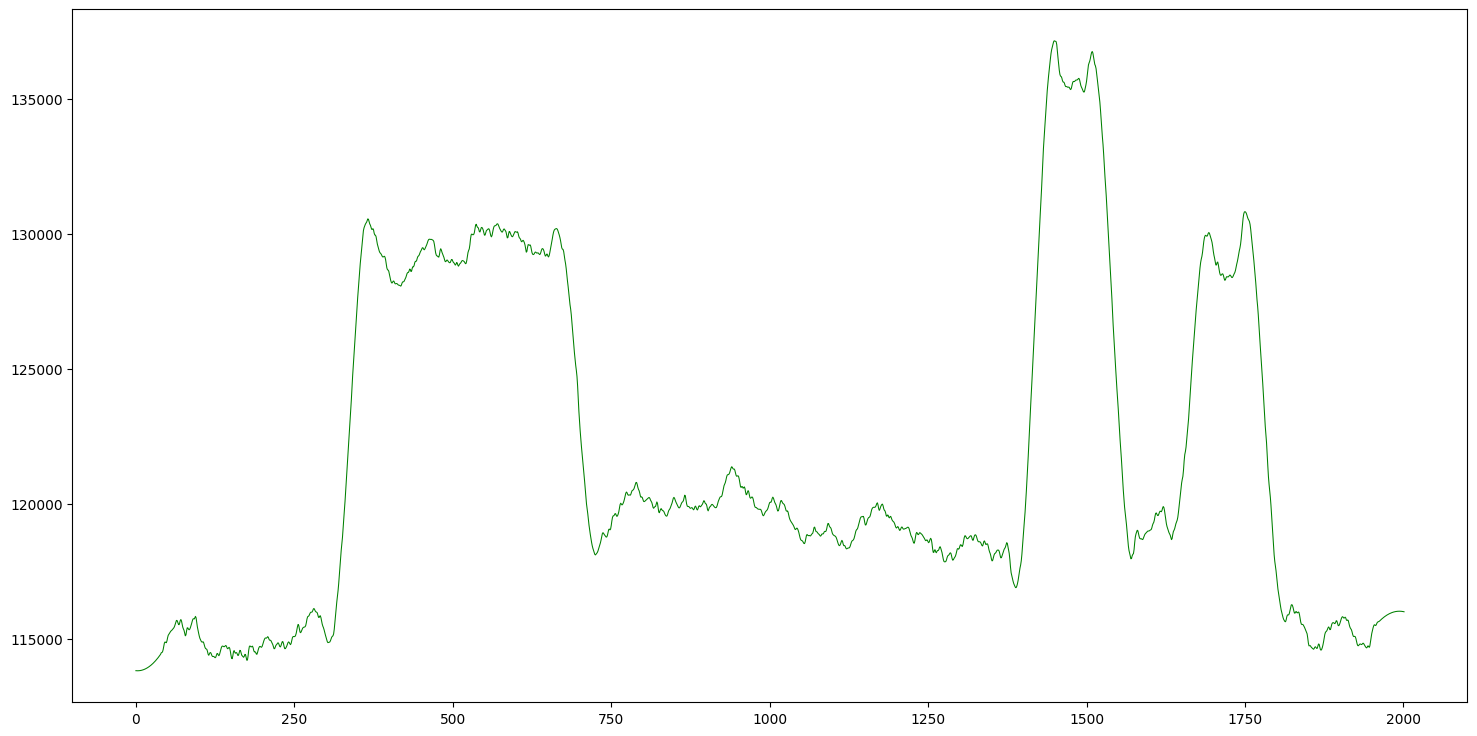

In [18]:
from scipy.signal import savgol_filter
from scipy.signal import lfilter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df=pd.read_csv("test.csv", header=None)
df=df.values.flatten() 
y2=savgol_filter(df, 80,2)
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
y1 = lfilter(b, a, df)
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),df,lw=0.75,label="Data",color="blue")
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),y1,lw=0.75,label="Data",color="red")
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),y2,lw=0.75,label="Data",color="green")
print(y1[1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2569.1638698222423
z
[-0.8990862852823062, -0.4397928887572947, 0.36202439670162356, 0.813533159387228, 0.28028574138785034, -0.6733319039395039, -1.2922102941723583, -1.2299332234571025, -0.6383010516621725, -0.058345830626353, -0.0038533937505041862, 0.050639043125344625, 0.5021478058109491, 0.7006559687158269, -0.038884246027835564, -1.1014867651068874, -1.7359344230185558, -1.658088084624486, -1.074240546668963, -0.24128472585241686, 0.36980903054103054, 0.5644248765262049, 0.24914720603022245, -0.505962276392254, -1.4790415063181257, -1.992827339718986, -1.7009035707412243, -0.7901014115306085, 0.13627001535882133, 0.5021478058109491, 0.04285440928593765, -0.3814081349617424, -0.15565375361894018, -0.01163802758991116, -0.7044704392971318, -1.393410534084649, -1.187117737340364, 0.17908550147555968, 2.062966890612047, 2.7752608869177853, 1.3000727743501639, -0.4397928887572947, -0.49428532563314354, 0.5488556088473909, 1.2261187528757975, 1.366242161985123, 1.1716263159999487, 0.8

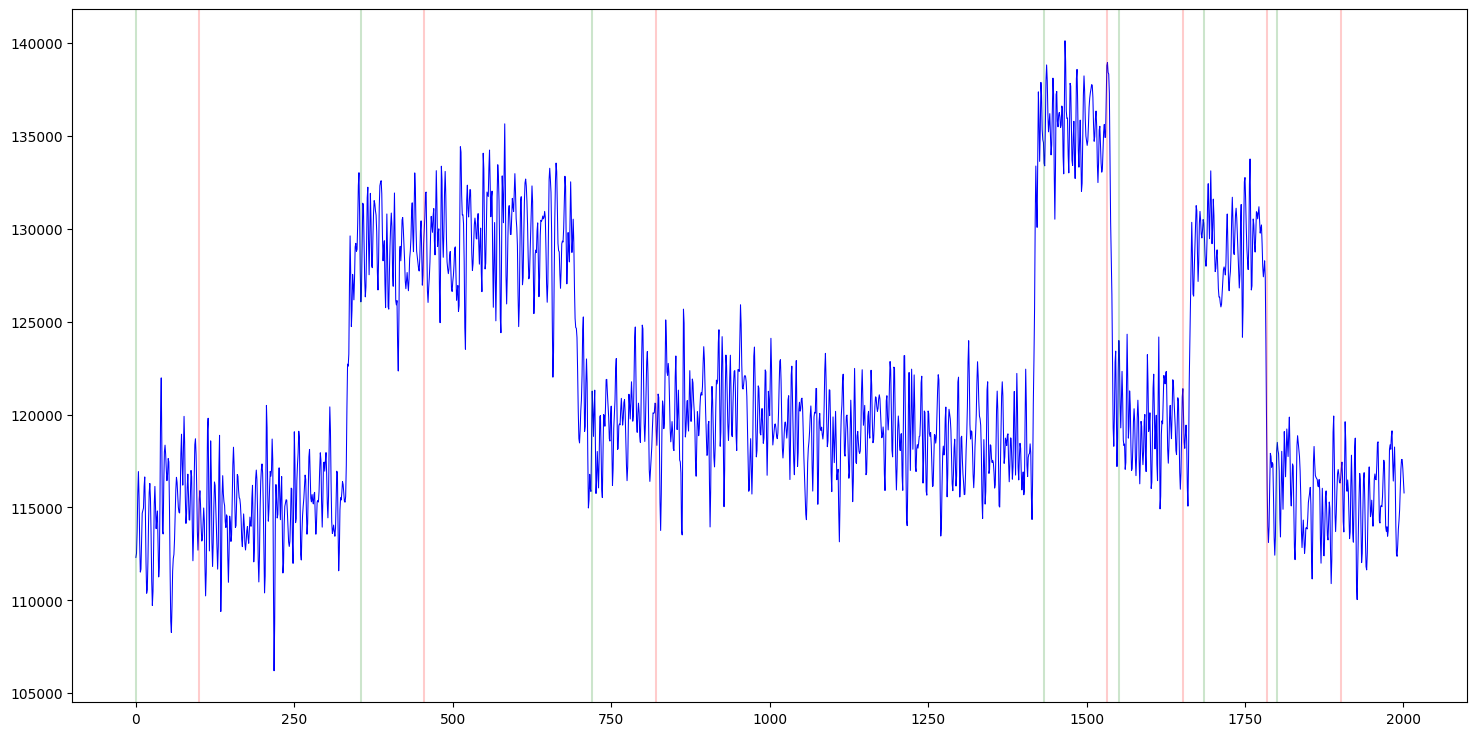

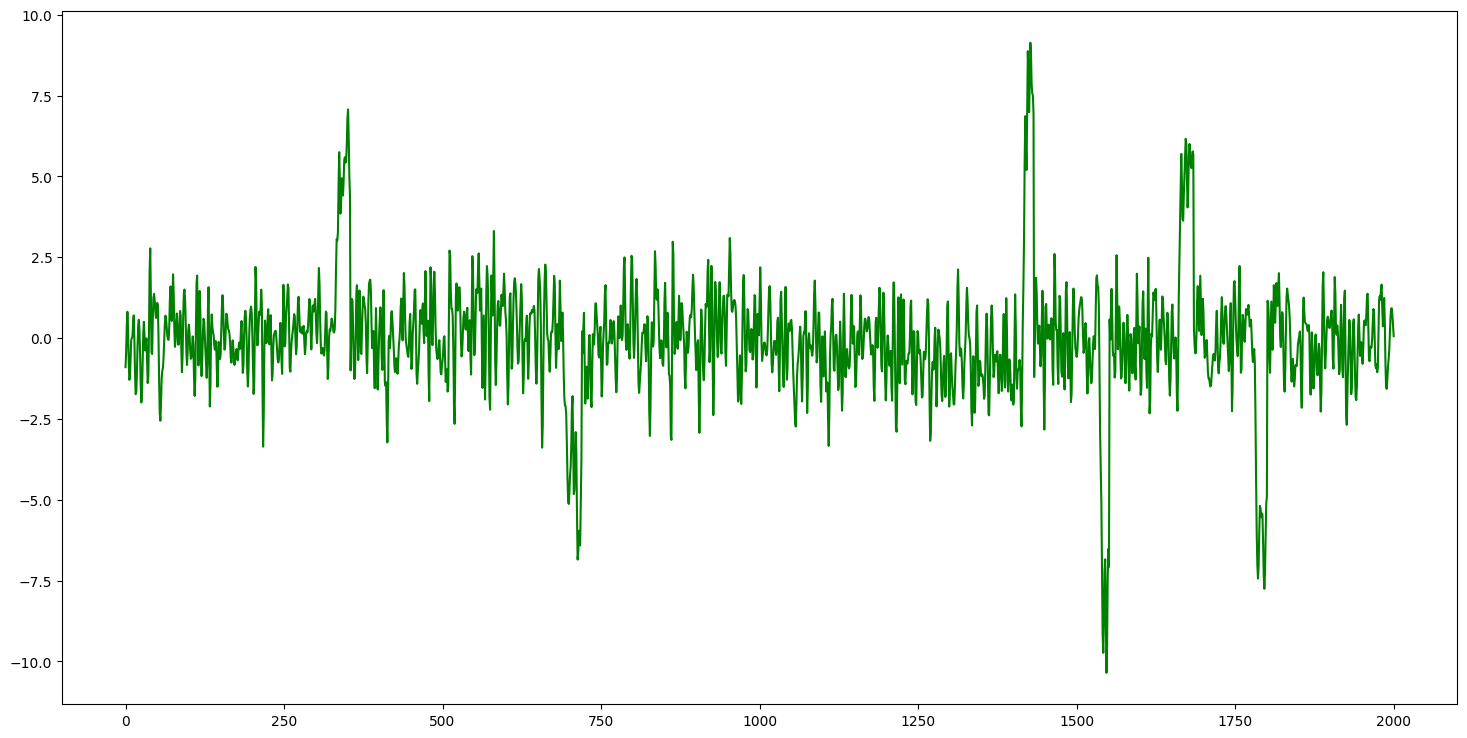

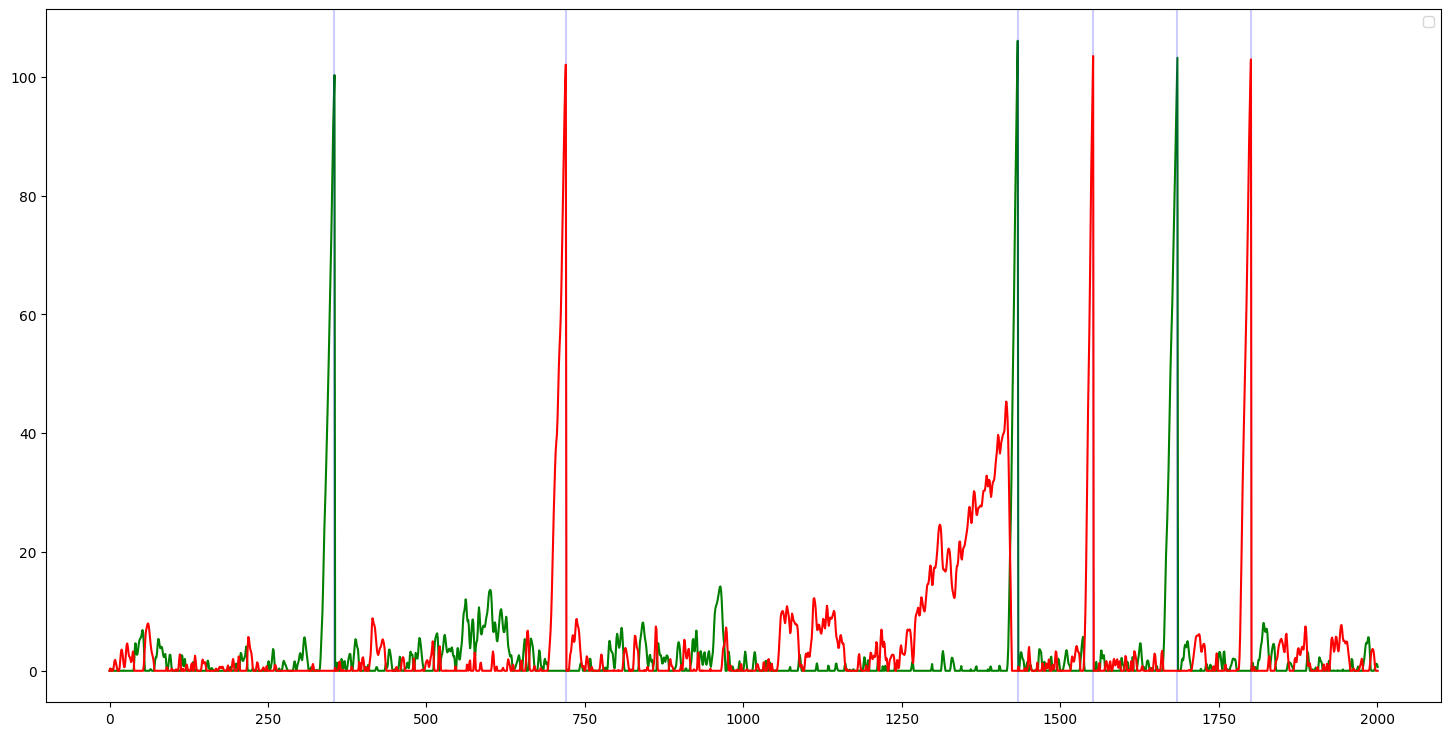

[[355], [720], [1433], [1552], [1685], [1801]]

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df=pd.read_csv("test.csv", header=None)
df=df.values.flatten()

GraphZscore(df,100,100)


- da cambiare il limite 100 in qualcosa di piu dinamico in base ai valori dello z score
- applicare la funzione alla energia cinetica.
- salvare i changepoint e mostrarlo in un grafico con delle delte di dirac? o delle rette..
- subito sotto mostrare un grafico simile usando il groundtruth per vedere quanto sono simili

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.006947583326481231
z
[-1.470732990139633, -1.4681421611917609, -1.4616650888220812, -1.463536243062211, -1.4698693804903422, -1.4275525076751008, -1.2562699272324558, -0.9031975156141298, -0.3703503620018008, 0.2587892675064353, 0.7989771031377345, 1.115490039602757, 1.197532956285368, 1.0734610366706119, 0.9017466514033218, 0.8749747522753114, 0.9539950351854057, 1.1268608999850835, 1.33772558935355, 1.4995084636539977, 1.646178169091859, 1.6818740345958723, 1.6267469519828197, 1.456903720955659, 1.2093356214923405, 0.9503966616466947, 0.6937606608658241, 0.48116875219877675, 0.244683643234688, 0.14608820827400584, 0.05209869144287395, -0.0050434803518573865, -0.09788151765060187, -0.16265224134740022, -0.20396156957180292, -0.20727207322741714, -0.24714205203633524, -0.2672929438531169, -0.26153554619117925, -0.28010315365092825, -0.3258744650633326, -0.3756759548390931, -0.43224238686763045, -0.5602005499041947, -0.693772175661148, -0.8641911464545022, -1.020360558034561, -1.20632

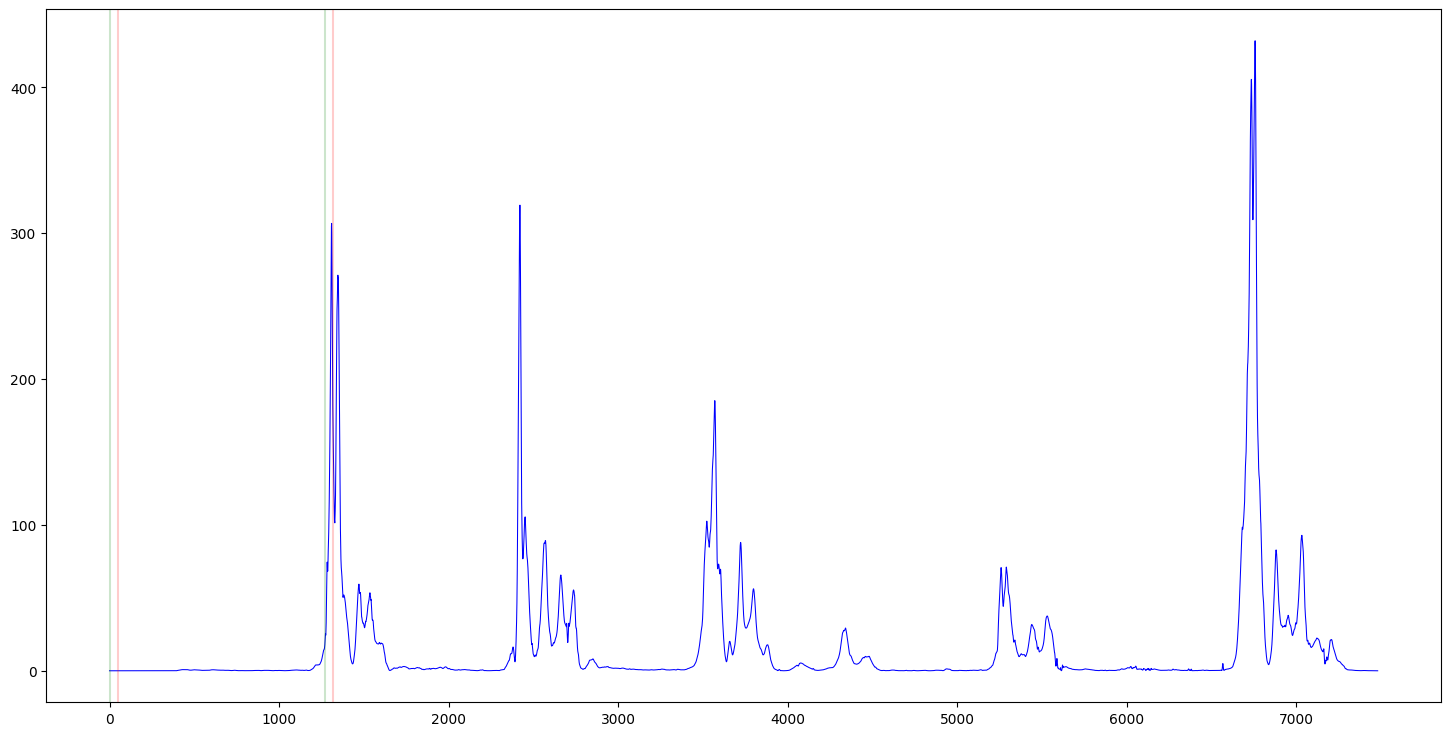

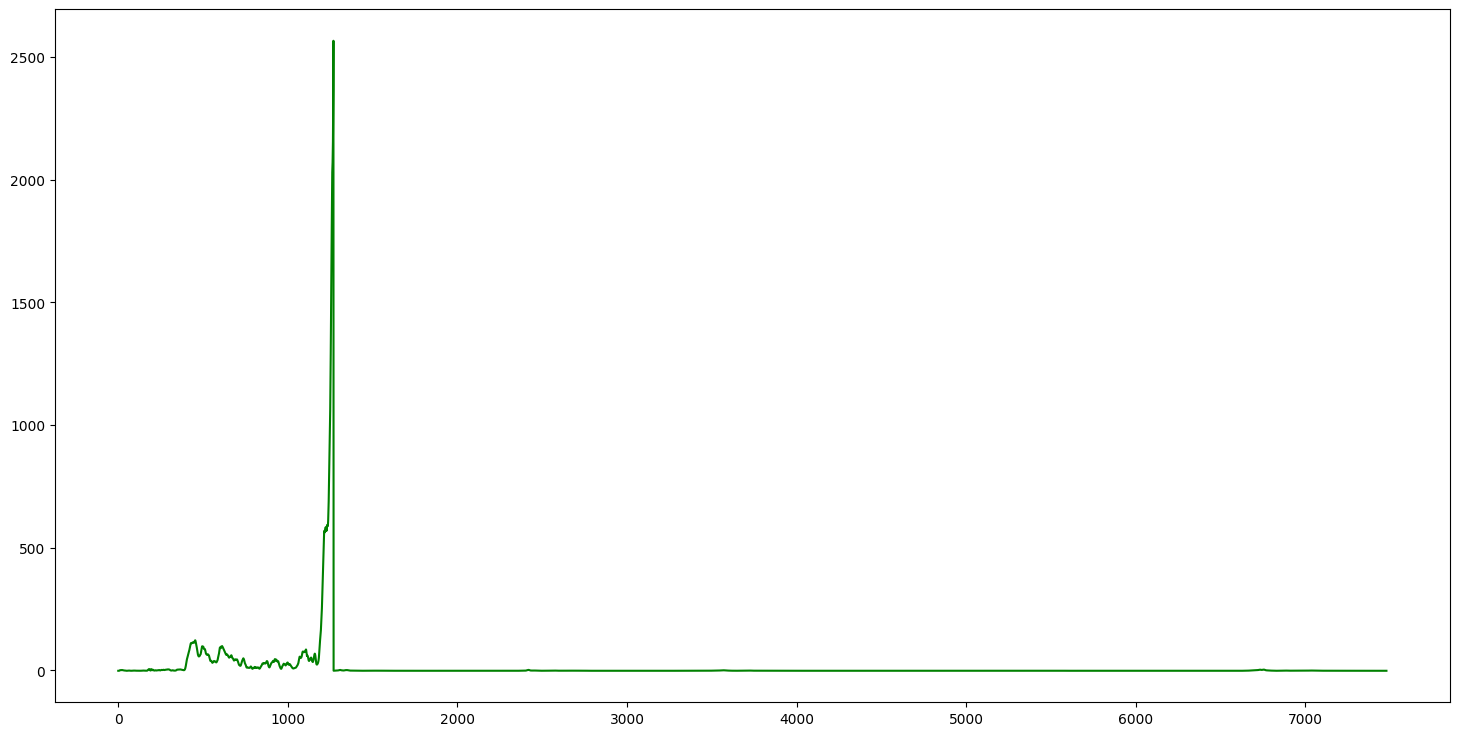

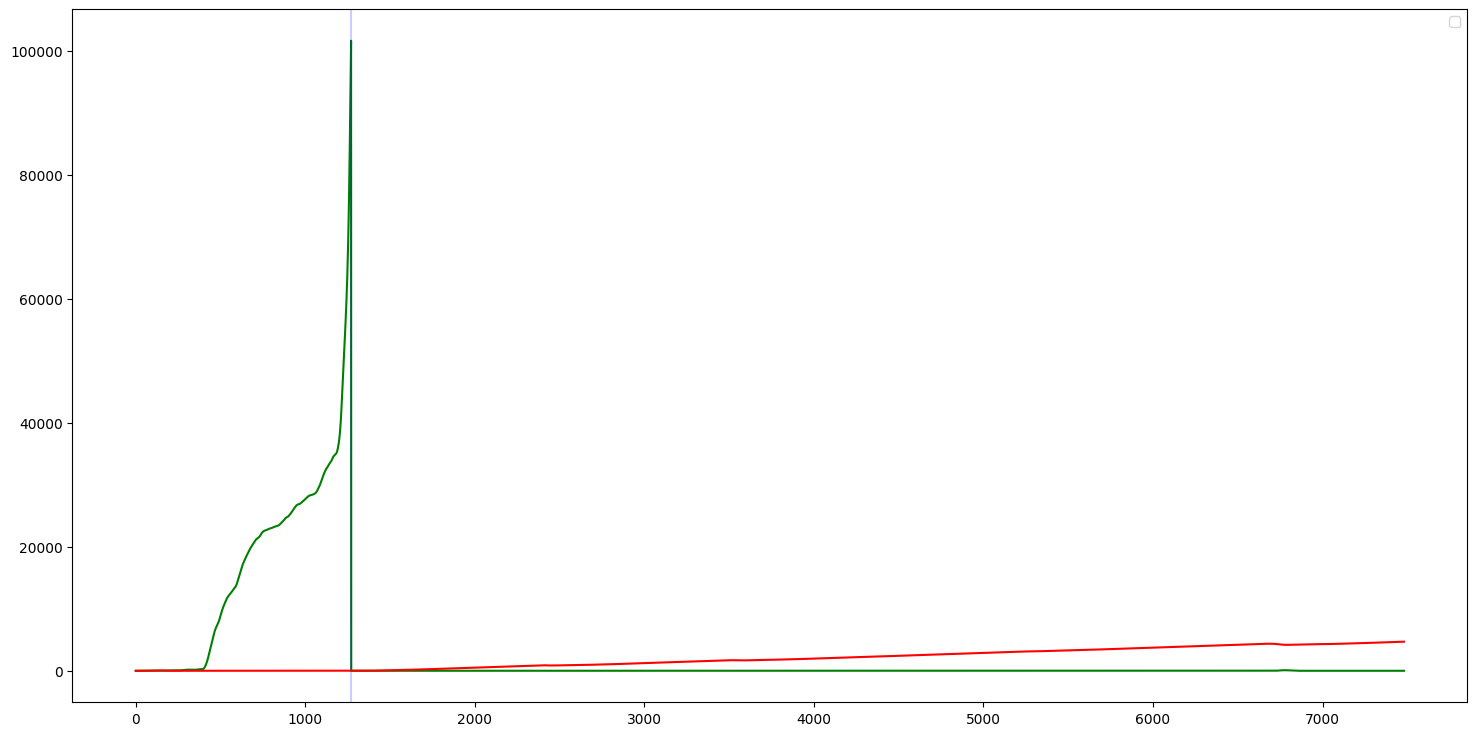

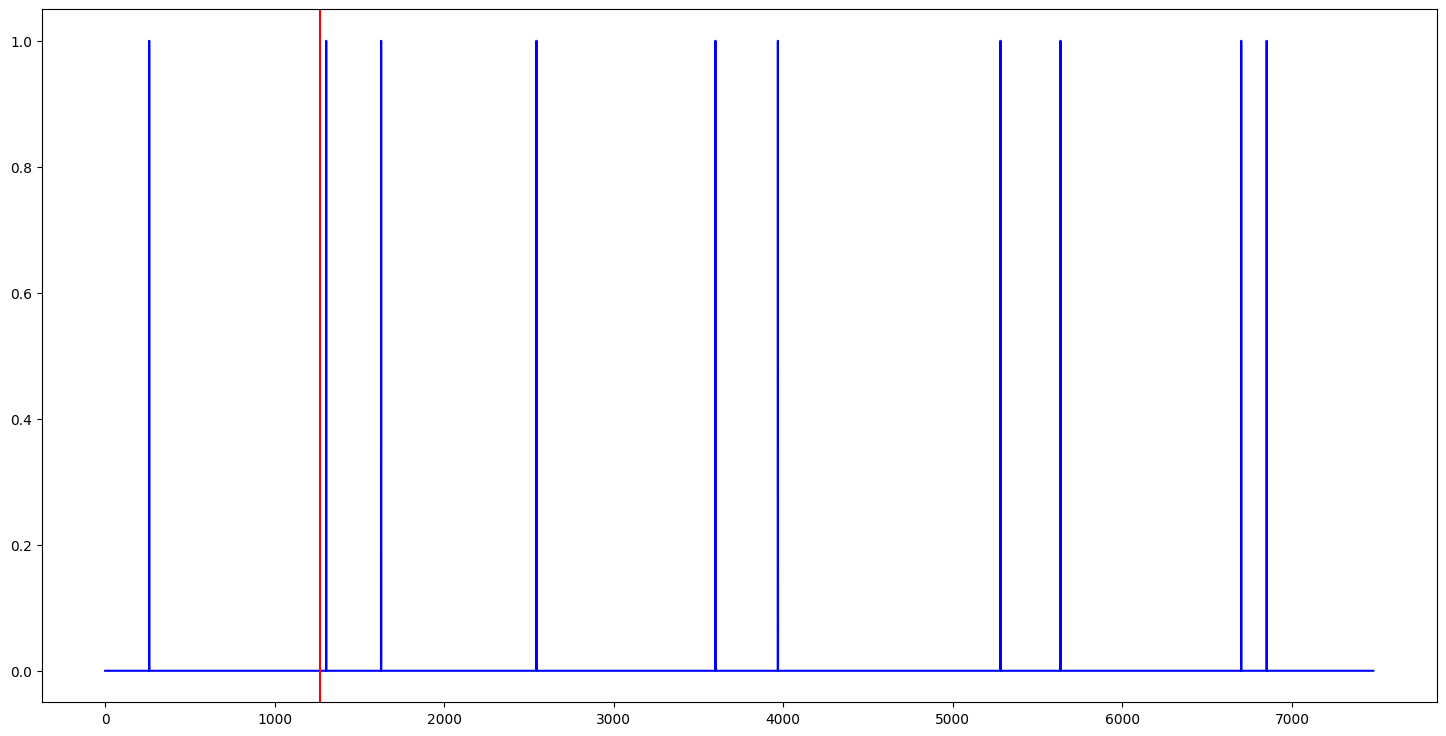

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df=pd.read_csv("2016-03-22_t024_only_chest.txt",sep=' ', header=None)
df=df.iloc[:,1].values
cp = GraphZscore(df,100000,50)

gt=pd.read_csv("GA_single_22-03-2016_t024_location_ground_truth.txt", header=None)
gt=gt.values.flatten()

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = [0] * len(df)
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):
    if i==1:
        relpos = idx*(100/len(gt))
        stretch_df[int(np.floor((len(stretch_df)/100)*relpos))]=1




plt.figure(figsize=(18,9))
#plt.plot(np.arange(len(gt)),gt,'g')
plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in cp:
    plt.axvline(x = j, color = 'red')

C:\Users\tikyn\AppData\Local\Temp\ipykernel_10428\2381946499.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(self._get_prob(standardized_sum).detach().numpy())


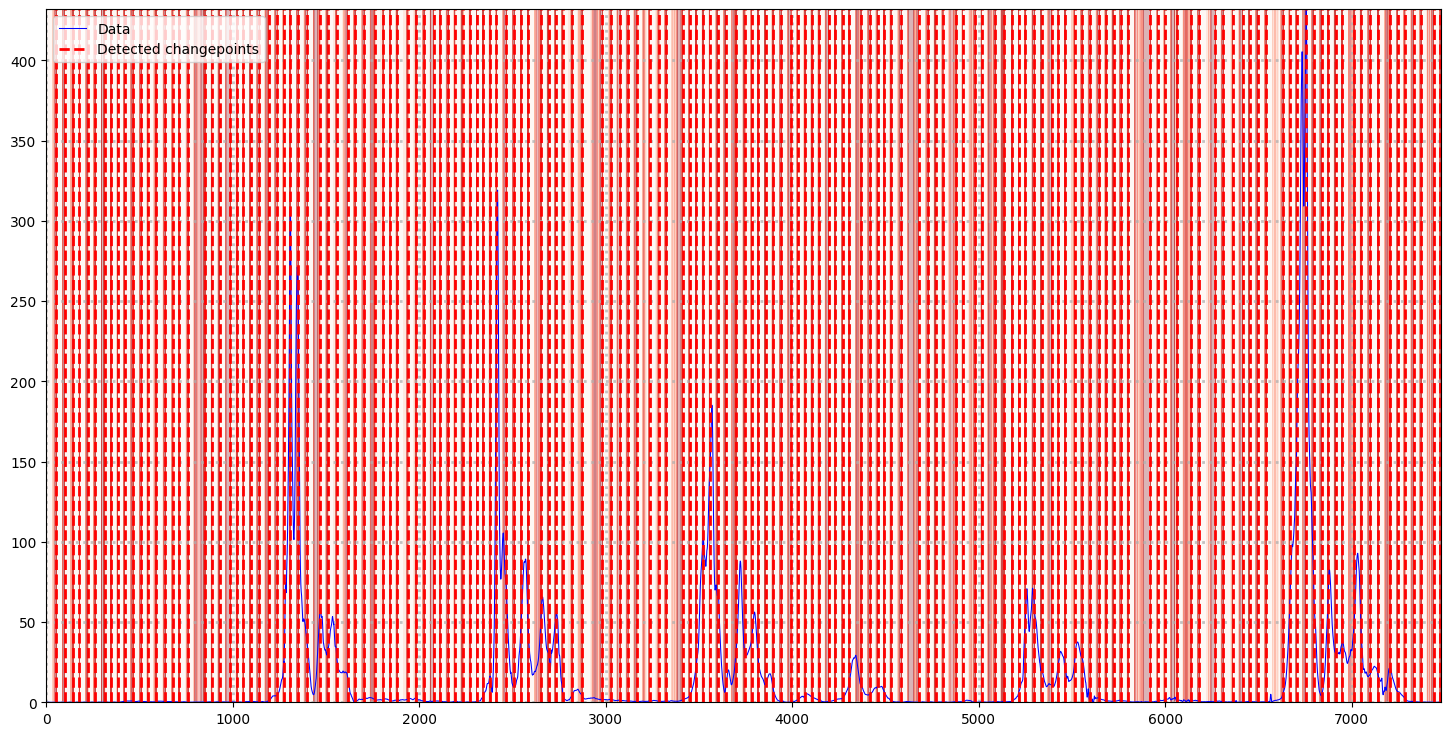

In [66]:
import matplotlib.pyplot as plt

import pandas as pd

import pandas as pd
#df=pd.read_csv("/content/test.csv", header=None, squeeze=True)

#y = torch.tensor(df.T.values)

df=pd.read_csv("2016-03-22_t024_only_chest.txt",sep=' ', header=None)
df=df.iloc[:,1].values
y = torch.tensor(df)

np.random.seed(456)
torch.manual_seed(456)

#segment_lengths = [np.random.randint(30,100) for _ in range(7)]
#y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])

test = CusumMeanDetector()
#outs = [test.predict_next(y[i][0]) for i in range(len(y))]

outs = [test.predict_next(y[i]) for i in range(len(y))]

cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()
plt.show()